# Mathematical Underpinnings - Lab 7

In [4]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-04-17 07:09:05.394069: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 07:09:05.397395: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 07:09:05.444890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 07:09:06.867707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Task 1

### a)

In [5]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return 0.5 * ((mu2-mu1) @ np.linalg.inv(Sigma2) @ (mu2-mu1) + np.trace(np.linalg.inv(Sigma2) @ Sigma1) - len(mu1) - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)))

In [10]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    px = np.exp(-0.5 * (x-mu1) @ np.linalg.inv(Sigma1) @ (x-mu1)) / np.sqrt((2*np.pi)**len(mu1) * np.linalg.det(Sigma1))
    qx = np.exp(-0.5 * (x-mu2) @ np.linalg.inv(Sigma2) @ (x-mu2)) / np.sqrt((2*np.pi)**len(mu1) * np.linalg.det(Sigma2))
    return np.log(px/qx)

### b)

In [11]:
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [12]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [13]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [25]:
t_x_opt = np.apply_along_axis(T_opt, 1, x, mu1, mu2, Sigma1, Sigma2)
DV_fun(y, t_x_opt)

2.208398822619853

### c)

In [17]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [33]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [35]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0444 - val_loss: -0.0081
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0077 - val_loss: -0.0395
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0329 - val_loss: -0.0572
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0530 - val_loss: -0.0674
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0551 - val_loss: -0.0737
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0693 - val_loss: -0.0777
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0680 - val_loss: -0.0807
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0743 - val_loss: -0.0828
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0831 - val_loss: -0.0848
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0867 - val_loss: -0.0866
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0783 - val_loss: -0.0883
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

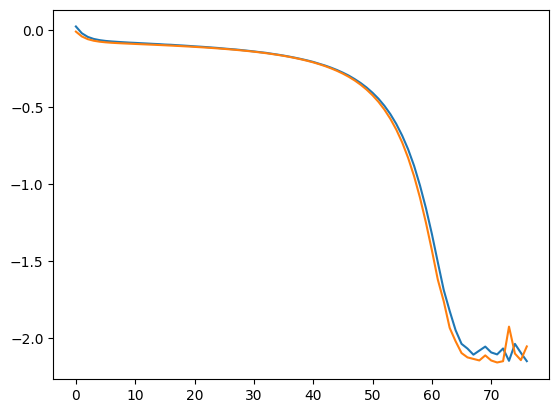

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [37]:
t_x_pred = model.predict(x)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step


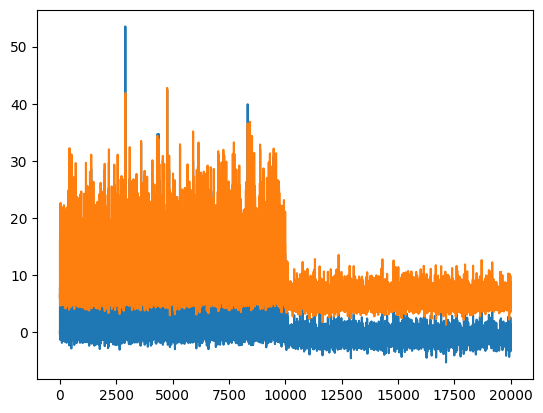

In [38]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

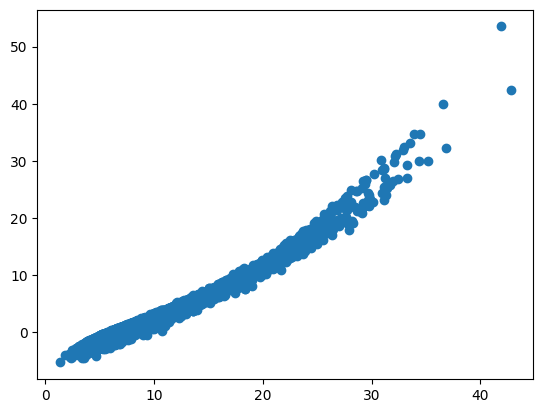

In [39]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [47]:
DV_fun(y, t_x_pred.flatten())

2.0641522257318554

In [48]:
DV_fun(y, t_x_opt)

2.208398822619853

In [49]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [50]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step


In [53]:
t_x_opt = np.apply_along_axis(T_opt, 1, x, mu1, mu2, Sigma1, Sigma2)

In [54]:
DV_fun(y_new, t_x_pred)

1.9404661586440088

In [55]:
DV_fun(y_new, t_x_opt)

2.208398822619853

### f)

In [56]:
def NWJ_loss(y_true, y_pred):
    first_term = tf.reduce_mean(y_pred[y_true==1])
    second_term = tf.reduce_mean(tf.math.exp(y_pred[y_true==0]-1))
    return  -(first_term - second_term)

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0955 - val_loss: -0.0493
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0591 - val_loss: -0.0641
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0708 - val_loss: -0.0727
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0797 - val_loss: -0.0785
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0789 - val_loss: -0.0828
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0783 - val_loss: -0.0863
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0885 - val_loss: -0.0893
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0851 - val_loss: -0.0917
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0995 - val_loss: -0.0943
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.1062 - val_loss: -0.0972
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.1065 - val_loss: -0.0999
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

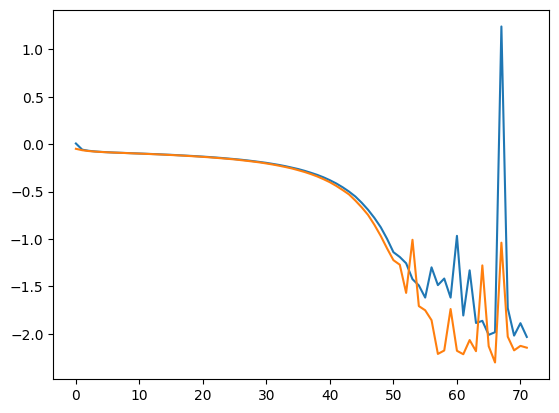

In [58]:
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model2 = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model2.compile(optimizer=optimizer, loss=NWJ_loss)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

hist = model2.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

  1/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


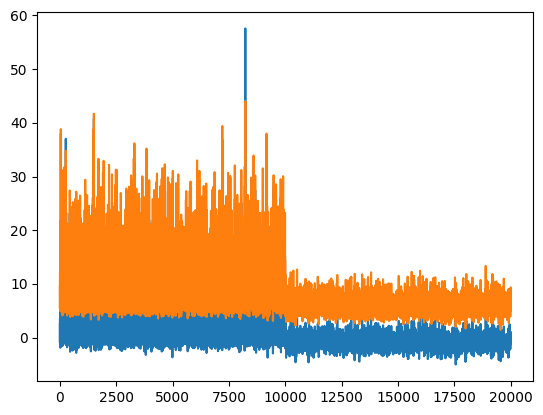

In [60]:
t_x_pred = model.predict(x)[:,0]
t_x_opt = np.apply_along_axis(T_opt, 1, x, mu1, mu2, Sigma1, Sigma2)
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

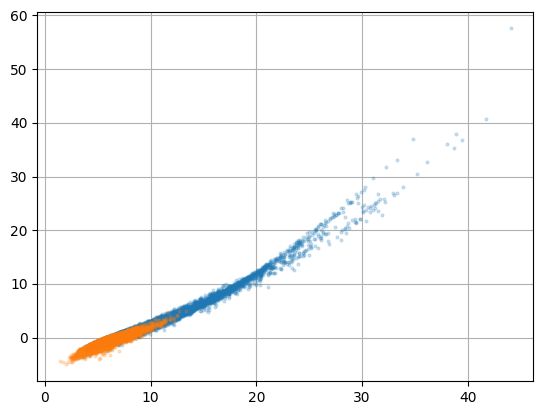

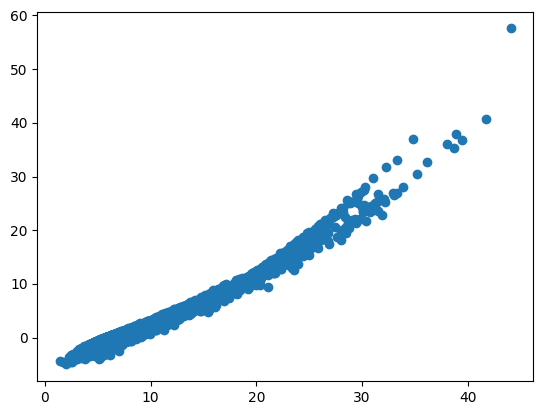

In [61]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()